##### Mole Classifier Kernel
In this kernel I have followed following 14 steps for model building and evaluation which are as follows : <br>
**Step 1 : Importing Essential Libraries**<br>
**Step 2: Loading pictures and making Dictionary of images and labels** <br>
**Step 3: Categorical Labels** <br>
**Step 4: Normalization** <br>
**Step 5: Train and Test Split** <br>
**Step 6: Model Building **<br>
**Step 7: Cross-validating model**<br>
**Step 8: Testing model**<br>
**Step 9: ResNet50** <br>

# Step 1 : importing Essential Libraries

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 

#Display the dir list
print(os.listdir("../input/dataset_tcdd"))

Using TensorFlow backend.


['test', 'train']


# Step 2 : Loading pictures and making Dictionary of images and labels
In this step I load in the pictures and turn them into numpy arrays using their RGB values. As the pictures have already been resized to 224x224, there's no need to resize them. As the pictures do not have any labels, these need to be created. Finally, the pictures are added together to a big training set and shuffeled.

In [2]:
folder_Class0_test = '../input/dataset_tcdd/test/Class2'
folder_Class1_test = '../input/dataset_tcdd/test/Class3'


ims_Class0 = [read(os.path.join(folder_Class0_test, filename)) for filename in os.listdir(folder_Class0_test)]
X_Class0_test = np.array(ims_Class0, dtype='uint8')
ims_Class1 = [read(os.path.join(folder_Class1_test, filename)) for filename in os.listdir(folder_Class1_test)]
X_Class1_test = np.array(ims_Class1, dtype='uint8')


NameError: name 'read' is not defined

In [3]:
folder_Class0_train = '../input/dataset_tcdd/train/Class0'
folder_Class1_train = '../input/dataset_tcdd/train/Class1'
folder_Class2_train = '../input/dataset_tcdd/train/Class2'
folder_Class3_train = '../input/dataset_tcdd/train/Class3'

folder_Class0_test = '../input/dataset_tcdd/test/Class0'
folder_Class1_test = '../input/dataset_tcdd/test/Class1'
folder_Class2_test = '../input/dataset_tcdd/test/Class2'
folder_Class3_test = '../input/dataset_tcdd/test/Class3'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_Class0 = [read(os.path.join(folder_Class0_train, filename)) for filename in os.listdir(folder_Class0_train)]
X_Class0 = np.array(ims_Class0, dtype='uint8')
ims_Class1 = [read(os.path.join(folder_Class1_train, filename)) for filename in os.listdir(folder_Class1_train)]
X_Class1 = np.array(ims_Class1, dtype='uint8')
ims_Class2 = [read(os.path.join(folder_Class2_train, filename)) for filename in os.listdir(folder_Class2_train)]
X_Class2 = np.array(ims_Class2, dtype='uint8')
ims_Class3 = [read(os.path.join(folder_Class3_train, filename)) for filename in os.listdir(folder_Class3_train)]
X_Class3 = np.array(ims_Class3, dtype='uint8')

# Load in testing pictures
ims_Class0 = [read(os.path.join(folder_Class0_test, filename)) for filename in os.listdir(folder_Class0_test)]
X_Class0_test = np.array(ims_Class0, dtype='uint8')
ims_Class1 = [read(os.path.join(folder_Class1_test, filename)) for filename in os.listdir(folder_Class1_test)]
X_Class1_test = np.array(ims_Class1, dtype='uint8')
ims_Class2 = [read(os.path.join(folder_Class2_test, filename)) for filename in os.listdir(folder_Class2_test)]
X_Class2_test = np.array(ims_Class2, dtype='uint8')
ims_Class3 = [read(os.path.join(folder_Class3_test, filename)) for filename in os.listdir(folder_Class3_test)]
X_Class3_test = np.array(ims_Class3, dtype='uint8')

# Create labels
y_Class0 = np.zeros(X_Class0.shape[0])
y_Class1 = np.ones(X_Class1.shape[0])
y_Class2 = np.zeros(X_Class2.shape[0])*2
y_Class3 = np.ones(X_Class3.shape[0])*3

y_Class0_test = np.zeros(X_Class0_test.shape[0])
y_Class1_test = np.ones(X_Class1_test.shape[0])
y_Class2_test = np.zeros(X_Class2_test.shape[0])*2
y_Class3_test = np.ones(X_Class3_test.shape[0])*3

# Merge data 
X_train = np.concatenate((X_Class0, X_Class1, X_Class2, X_Class3), axis = 0)
y_train = np.concatenate((y_Class0, y_Class1, y_Class2, y_Class3), axis = 0)

X_test = np.concatenate((X_Class0_test, X_Class1_test, X_Class2_test, X_Class3_test), axis = 0)
y_test = np.concatenate((y_Class0_test, y_Class1_test, y_Class2_test, y_Class3_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

ValueError: setting an array element with a sequence.

NameError: name 'y_train' is not defined

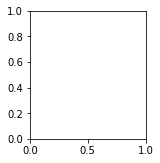

In [4]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Class0')
    else:
        ax.title.set_text('Class1')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Step 3: Categorical Labels
Turn labels into one hot encoding

In [5]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

NameError: name 'y_train' is not defined

# Step 4 : Normalization
Normalize all Values of the pictures by dividing all the RGB values by 255

In [6]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

NameError: name 'X_train' is not defined

# Step 5: Model Building 
## CNN
I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 64 filters for the two firsts conv2D layers. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in one fully-connected (Dense) layer which is just artificial an neural networks (ANN) classifier.

In [7]:
# See learning curve and validation curve

def build(input_shape= (85,244,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)



In [8]:
input_shape = (85,244,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 85, 244, 64)       1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 122, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 122, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 122, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 61, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)  

NameError: name 'X_train' is not defined

In [9]:
K.clear_session()
del model
del history

NameError: name 'history' is not defined

# Step 6: Cross-Validating Model


In [10]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

NameError: name 'X_train' is not defined

# Step 7: Testing the model

First the model has to be fitted with all the data, such that no data is left out.

In [11]:
# Fitting model to all data
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
y_pred = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 85, 244, 64)       1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 122, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 122, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 122, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 61, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 61, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 81984)             0         
__________

NameError: name 'X_train' is not defined

In [12]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
K.clear_session()

Saved model to disk


# Step 8: ResNet50
The CNN above is not a very sophisticated model, thus the resnet50, is also tried

In [13]:
input_shape = (85,244,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



NameError: name 'X_train' is not defined

In [14]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )


NameError: name 'X_train' is not defined

In [15]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

NameError: name 'X_test' is not defined